#### This notebook works well with Python 3 Data Science Kernel

In [18]:
# Number of Autopilot candidates to evaluate and run batch transform jobs.
# Make sure that you do not put a larger TOP_N_CANDIDATES than the Batch Transform limit for ml.m5.xlarge instances in your account.
TOP_N_CANDIDATES = 1

# Top Candidates for Supervised Fraud Detection with Amazon SageMaker Autopilot and Batch Transform (Python SDK)
_**Using AutoPilot to Predict Fraud with the Python SDK**_

---

---

This notebook works with sagemaker python sdk 2.x

## Contents

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Settingup)
1. [Autopilot Results](#Results)
1. [Evaluate Top Candidates](#Evaluation)
1. [Cleanup](#Cleanup)


---

## Introduction

Amazon SageMaker Autopilot is an automated machine learning (commonly referred to as AutoML) solution for tabular datasets. You can use SageMaker Autopilot in different ways: on autopilot (hence the name) or with human guidance, without code through SageMaker Studio, or using the AWS SDKs. This notebook, as a first glimpse, will use the AWS SDKs to simply create and deploy a machine learning model.

With the new feature released on 6/19/2020 (sagemaker python sdk >= 1.65.1), Autopilot generated models can be configured to return probabilities of each inference. This will enable data scientists to further analyze the performance of the model with additional metrics and to choose an appropriate threshold as operating point. This notebook demonstrate how to configure the model to obtain the inference probability (see [Customize the Inference Response](#Customize-the-Inference-Response)), select top N models, and make Batch Transform on a hold-out test set for evaluation. Note that this feature only works with Autopilot models created after the release of the new feature, i.e. after 6/19/2020, you will have to rerun Autopilot jobs to recreate the models in order to obtain the probability score during inference.


In this notebook, we use the high-level [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk).

---
## Setup

_This notebook was created and tested on an ml.t3.medium notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).
- The number of top candidates (`TOP_N_CANDIDATES`) to explore and compare with different metrics  (AUC, Precision-recall and ROC) on the heldout data split. We demonstrate how to compute these metrics for each candidate by running transform jobs. (Note that `TOP_N_CANDIDATES` was defined in the first cell of this notebook). 

In [3]:
# to get the latest sagemaker python sdk
!pip install -U sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [4]:
import sagemaker
import boto3
from sagemaker import get_execution_role

print(sagemaker.__version__)

region = boto3.Session().region_name

session = sagemaker.Session()

# You can modify the following to use a bucket of your choosing
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-autopilot-fraud"

role = get_execution_role()

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

2.69.0


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import AutoML
from time import gmtime, strftime, sleep
from pprint import pprint
import json
import io
from urllib.parse import urlparse
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    average_precision_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt

### Inspect your Dataset

Before you run Autopilot on the dataset, first perform a check of the dataset to make sure that it has no obvious errors. The Autopilot process can take long time, and it's generally a good practice to inspect the dataset before you start a job. This particular dataset is small, so you can inspect it in the notebook instance itself. If you have a larger dataset that will not fit in a notebook instance memory, inspect the dataset offline using a big data analytics tool like Apache Spark. [Deequ](https://github.com/awslabs/deequ) is a library built on top of Apache Spark that can be helpful for performing checks on large datasets. Autopilot is capable of handling datasets up to 5 GB.

Read the data into a Pandas data frame and take a look.

In [41]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import io

s3_client = boto3.client('s3', region_name=region)

fraud_detection_bucket_name = bucket
data_file_key = 'data/fraud-detection/credit-dataset.csv'

data_object = s3_client.get_object(Bucket=fraud_detection_bucket_name, Key=data_file_key)

transaction_data = pd.read_csv(io.BytesIO(data_object['Body'].read()))

transaction_data = transaction_data[['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class']]


transaction_data.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Reserve some data for calling inference on the model

Divide the data into training and testing splits. The training split is used by SageMaker Autopilot. The testing split is reserved to perform inference using the suggested model.

In [44]:
train_data = transaction_data.sample(frac=0.8, random_state=200)

test_data = transaction_data.drop(train_data.index)

test_data_no_target = test_data.drop(columns=["class"])

Let's save these train and test data splits to csv files locally

In [45]:
train_file = "train_data.csv"
train_data.to_csv(train_file, index=False, header=True)

test_file = "test_data.csv"
test_data_no_target.to_csv(test_file, index=False, header=False)

## Setting up the SageMaker Autopilot Job<a name="Settingup"></a>

We will use the `AutoML` estimator from SageMaker Python SDK to invoke Autopilot to find the best ML pipeline to train a model on this dataset. 

The required inputs for invoking a Autopilot job are:
* local or s3 location for input dataset (if local, the dataset will be uploaded to s3)
* Name of the column of the dataset you want to predict (`class` in this case) 
* An IAM role

Currently Autopilot supports only tabular datasets in CSV format. Either all files should have a header row, or the first file of the dataset, when sorted in alphabetical/lexical order by name, is expected to have a header row.

In [46]:
from sagemaker import AutoML
from time import gmtime, strftime, sleep

timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
base_job_name = "automl-fraud-" + timestamp_suffix

target_attribute_name = "class"
target_attribute_values = np.unique(train_data[target_attribute_name])
target_attribute_true_value = target_attribute_values[1]  # 'True.'

automl = AutoML(
    role=role,
    target_attribute_name=target_attribute_name,
    base_job_name=base_job_name,
    sagemaker_session=session,
    max_candidates=3,
)

You can also specify the type of problem you want to solve with your dataset (`Regression, MulticlassClassification, BinaryClassification`) with the `problem_type` keywork argument. In case you are not sure, SageMaker Autopilot will infer the problem type based on statistics of the target column (the column you want to predict). 

Because the target attribute, ```class```, is binary, our model will be performing binary prediction, also known as binary classification. In this example we will let AutoPilot infer the type of problem for us.

You have the option to limit the running time of a SageMaker Autopilot job by providing either the maximum number of pipeline evaluations or candidates (one pipeline evaluation is called a `Candidate` because it generates a candidate model) or providing the total time allocated for the overall Autopilot job. Under default settings, this job takes about four hours to run. This varies between runs because of the nature of the exploratory process Autopilot uses to find optimal training parameters.

We limit the number of candidates to 3 so that the job finishes in a few minutes.

### Launching the SageMaker Autopilot Job<a name="Launching"></a>

You can now launch the Autopilot job by calling the `fit` method of the `AutoML` estimator.

In [47]:
automl.fit(train_file, job_name=base_job_name, wait=False, logs=False)

### Tracking SageMaker Autopilot Job Progress<a name="Tracking"></a>
SageMaker Autopilot job consists of the following high-level steps : 
* Analyzing Data, where the dataset is analyzed and Autopilot comes up with a list of ML pipelines that should be tried out on the dataset. The dataset is also split into train and validation sets.
* Feature Engineering, where Autopilot performs feature transformation on individual features of the dataset as well as at an aggregate level.
* Model Tuning, where the top performing pipeline is selected along with the optimal hyperparameters for the training algorithm (the last stage of the pipeline). 

We can use the `describe_auto_ml_job` method to check the status of our SageMaker Autopilot job.

In [ ]:
print("JobStatus - Secondary Status")
print("------------------------------")


describe_response = automl.describe_auto_ml_job()
print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"])
job_run_status = describe_response["AutoMLJobStatus"]

while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = automl.describe_auto_ml_job()
    job_run_status = describe_response["AutoMLJobStatus"]

    print(
        describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"]
    )
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - Starting
InProgress - Starting
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgres

---
## Describing the SageMaker Autopilot Job Results <a name="Results"></a>

We can use the `describe_auto_ml_job` method to look up the best candidate generated by the SageMaker Autopilot job. This notebook demonstrate end-to-end Autopilot so that we have a already initialized `automl` object. 

**Note: Using Another Autopilot Job**

If you want to retrieve a previous Autopilot job or an Autopilot job launched outside of this notebook, such as from the SageMaker Studio UI, from the CLI, etc, you can use the following lines to prior to the next cell. If you are using a different dataset, you must also override the following variables defined in the [Data](#Data) section in order to run the batch jobs and perform the analysis: `test_data`, `test_data_no_target`, `test_file`, `target_attribute_name`, `target_attribute_values`, and `target_attribute_true_value`.

```python
from sagemaker import AutoML
automl = AutoML.attach(auto_ml_job_name='<autopilot-job-name>')

test_data = ... # test_data to be used (with target column)
test_data_no_target = ... # test_data to be used (without target column)
test_file = ... # path of data to upload to S3 and perform batch inference (csv file of test_data_no_target)
target_attribute_name = ... # name of target column (values to predict)
target_attribute_values = ... # list of unique values in target column (sorted)
target_attribute_true_value = ... # second value in target column (binary classification "True" class)

```

In [ ]:
best_candidate = automl.describe_auto_ml_job()["BestCandidate"]
best_candidate_name = best_candidate["CandidateName"]
pprint(best_candidate)
print("\n")
print("CandidateName: " + best_candidate_name)
print(
    "FinalAutoMLJobObjectiveMetricName: "
    + best_candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"]
)
print(
    "FinalAutoMLJobObjectiveMetricValue: "
    + str(best_candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
)

{'CandidateName': 'automl-fraud-25-11-06-46n65wINIH-001-64dc8a2f',
 'CandidateProperties': {'CandidateArtifactLocations': {'Explainability': 's3://sagemaker-us-east-1-365792799466/automl-fraud-25-11-06-46/documentation/explainability/output'},
                         'CandidateMetrics': [{'MetricName': 'F1',
                                               'Set': 'Validation',
                                               'Value': 0.48627999424934387},
                                              {'MetricName': 'AUC',
                                               'Set': 'Validation',
                                               'Value': 0.9818000197410583},
                                              {'MetricName': 'Accuracy',
                                               'Set': 'Validation',
                                               'Value': 0.9971399903297424}]},
 'CandidateStatus': 'Completed',
 'CandidateSteps': [{'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:3657927

Due to some randomness in the algorithms involved, different runs will provide slightly different results.

### Check Top Candidates

In addition to the `best_candidate`, we can also explore the other top candidates generated by SageMaker Autopilot. 

We use the `list_candidates` method to see our other top candidates.

In [19]:
TOP_N_CANDIDATES  # number of top candidates to check, defined at the beginning of the notebook

1

In [20]:
candidates = automl.list_candidates(
    sort_by="FinalObjectiveMetricValue", sort_order="Descending", max_results=TOP_N_CANDIDATES
)

for candidate in candidates:
    print("Candidate name: ", candidate["CandidateName"])
    print("Objective metric name: ", candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"])
    print("Objective metric value: ", candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
    print("\n")

Candidate name:  automl-fraud-25-07-13-32PvU0MNrv-003-52b63a7e
Objective metric name:  validation:f1_binary
Objective metric value:  0.44523000717163086




---
## Evaluate Top Candidates <a name="Evaluation"></a>

Once our SageMaker Autopilot job has finished, we can start running inference on the top candidates. In SageMaker, you can perform inference in two ways: online endpoint inference or batch transform inference. Lets focus on batch transform inference.

We'll perform batch transform on our top candidates and analyze some custom metrics from our top candidates' prediction results.

### Upload Data for Transform Jobs

We'll use the `test_data` which we defined when we split out data in train and test splits. We need to upload this data to S3. As a refresher, here's `test_data`

In [21]:
test_data.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0
10,10.0,1.449044,-1.176339,0.913860,-1.375667,-1.971383,-0.629152,-1.423236,0.048456,-1.720408,...,-0.009302,0.313894,0.027740,0.500512,0.251367,-0.129478,0.042850,0.016253,7.80,0
13,11.0,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0


In [22]:
input_data_transform = session.upload_data(path=test_file, bucket=bucket, key_prefix=prefix)
print("Uploaded transform data to {}".format(input_data_transform))

Uploaded transform data to s3://sagemaker-us-east-1-365792799466/sagemaker/DEMO-autopilot-fraud/test_data.csv


### Customize the Inference Response

For classification problem types, the inference containers generated by SageMaker Autopilot allow you to select the response content for predictions. Valid inference response content are defined below for binary classification and multiclass classification problem types.

- `'predicted_label'` - predicted class
- `'probability'` - In binary classification, the probability that the result is predicted as the second or `True` class in the target column. In multiclass classification, the probability of the winning class.
- `'labels'` - list of all possible classes
- `'probabilities'` - list of all probabilities for all classes (order corresponds with `'labels'`)

By default the inference contianers are configured to generate the `'predicted_label'`.

In this example we use `‘predicted_label’` and `‘probability’` to demonstrate how to evaluate the models with custom metrics. For the Churn dataset, the second or `True` class is the string`'True.'`


In [23]:
inference_response_keys = ["predicted_label", "probability"]

### Create the Models and Tranform Estimators

Let's create our Models and Batch Transform Estimators using the `create_model` method. We can specify our inference response using the `inference_response_keys` keyword argument.

In [24]:
s3_transform_output_path = "s3://{}/{}/inference-results/".format(bucket, prefix)

transformers = []

for candidate in candidates:
    model = automl.create_model(
        name=candidate["CandidateName"],
        candidate=candidate,
        inference_response_keys=inference_response_keys,
    )

    output_path = s3_transform_output_path + candidate["CandidateName"] + "/"

    transformers.append(
        model.transformer(
            instance_count=1,
            instance_type="ml.m5.xlarge",
            assemble_with="Line",
            output_path=output_path,
        )
    )

print("Setting up {} Batch Transform Jobs in `transformers`".format(len(transformers)))

Setting up 1 Batch Transform Jobs in `transformers`


### Start the Transform Jobs

Let's start all the transform jobs.

In [25]:
for transformer in transformers:
    transformer.transform(
        data=input_data_transform, split_type="Line", content_type="text/csv", wait=False
    )
    print("Starting transform job {}".format(transformer._current_job_name))

Starting transform job automl-fraud-25-07-13-32PvU0MNrv-003-52-2021-11-25-07-58-18-614


Now we wait for our transform jobs to finish.

In [26]:
pending_complete = True

while pending_complete:
    pending_complete = False
    num_transform_jobs = len(transformers)
    for transformer in transformers:
        desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
        if desc["TransformJobStatus"] not in ["Failed", "Completed"]:
            pending_complete = True
        else:
            num_transform_jobs -= 1
    print("{} out of {} transform jobs are running.".format(num_transform_jobs, len(transformers)))
    sleep(30)

for transformer in transformers:
    desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
    print(
        "Transform job '{}' finished with status {}".format(
            transformer._current_job_name, desc["TransformJobStatus"]
        )
    )

1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
1 out of 1 transform jobs are running.
0 out of 1 transform jobs are running.
Transform job 'automl-fraud-25-07-13-32PvU0MNrv-003-52-2021-11-25-07-58-18-614' finished with status Completed


### Evaluate the Inference Results

Now we analyze our inference results. The batch transform results are stored in S3. So we define a helper method to get the results from S3.

In [27]:
import json
import io
from urllib.parse import urlparse


def get_csv_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:].strip("/")
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")

In [28]:
predictions = []

for transformer in transformers:
    print(transformer.output_path)
    pred_csv = get_csv_from_s3(transformer.output_path, "{}.out".format(test_file))
    predictions.append(pd.read_csv(io.StringIO(pred_csv), header=None))

s3://sagemaker-us-east-1-365792799466/sagemaker/DEMO-autopilot-fraud/inference-results/automl-fraud-25-07-13-32PvU0MNrv-003-52b63a7e/


We will use the `sklearn.metrics` module to analyze our prediction results.

In [29]:
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    average_precision_score,
)
import matplotlib.pyplot as plt

labels = test_data[target_attribute_name].apply(
    lambda row: True if row == target_attribute_true_value else False
)

# calculate auc score
for prediction, candidate in zip(predictions, candidates):
    roc_auc = roc_auc_score(labels, prediction.loc[:, 1])
    ap = average_precision_score(labels, prediction.loc[:, 1])
    print(
        "%s's ROC AUC = %.2f, Average Precision = %.2f" % (candidate["CandidateName"], roc_auc, ap)
    )
    print(classification_report(test_data[target_attribute_name], prediction.loc[:, 0]))
    print()

automl-fraud-25-07-13-32PvU0MNrv-003-52b63a7e's ROC AUC = 0.98, Average Precision = 0.67
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.29      0.86      0.43        98

    accuracy                           1.00     56961
   macro avg       0.64      0.93      0.71     56961
weighted avg       1.00      1.00      1.00     56961




Plot the ROC curve.

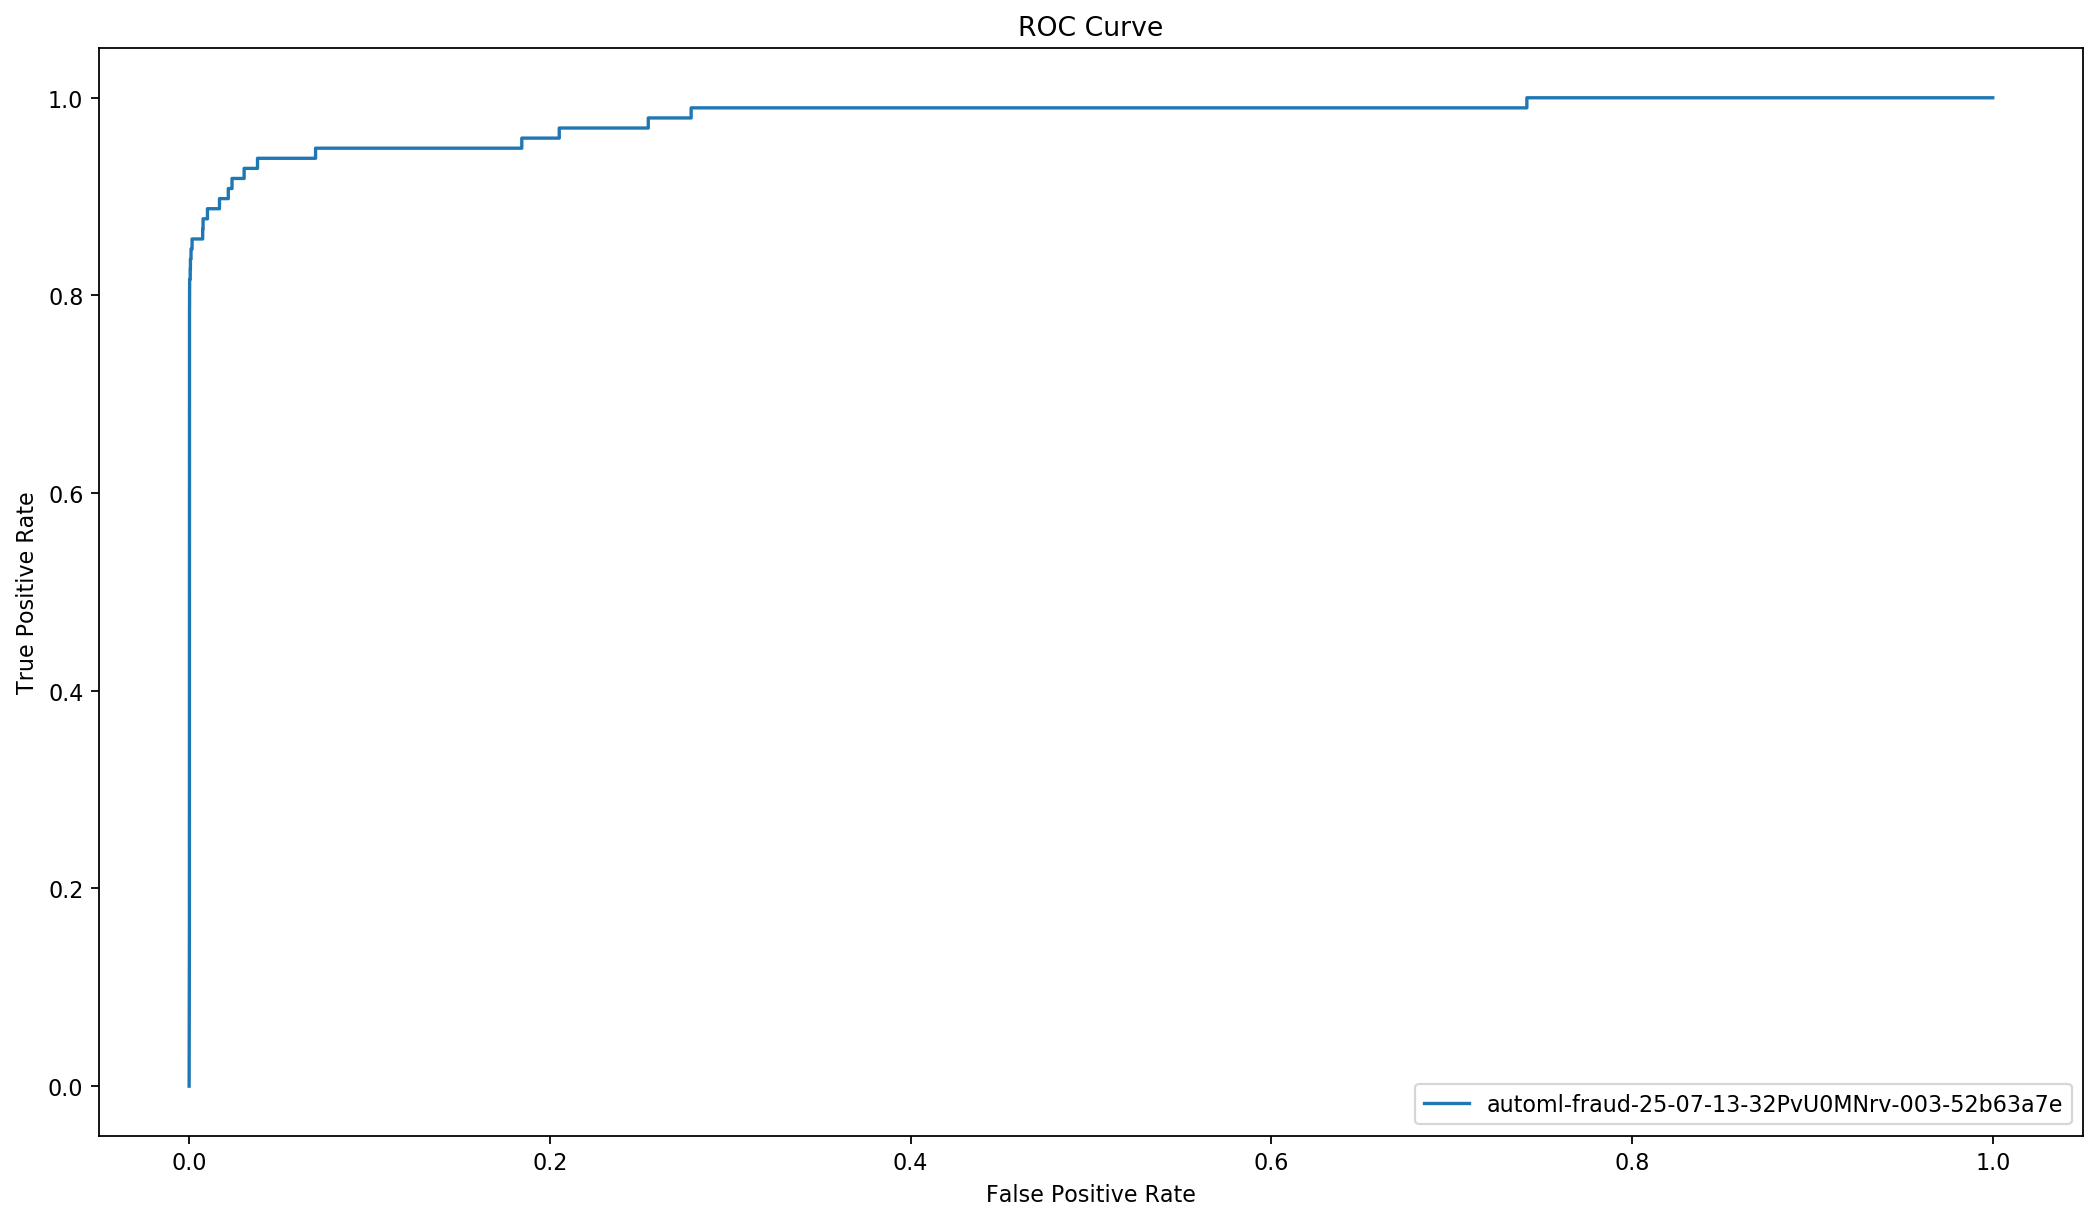

In [30]:
fpr_tpr = []
for prediction in predictions:
    fpr, tpr, _ = roc_curve(labels, prediction.loc[:, 1])
    fpr_tpr.append(fpr)
    fpr_tpr.append(tpr)

plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor="w", edgecolor="k")
plt.plot(*fpr_tpr)
plt.legend([candidate["CandidateName"] for candidate in candidates], loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

Plot the precision-recall curve.

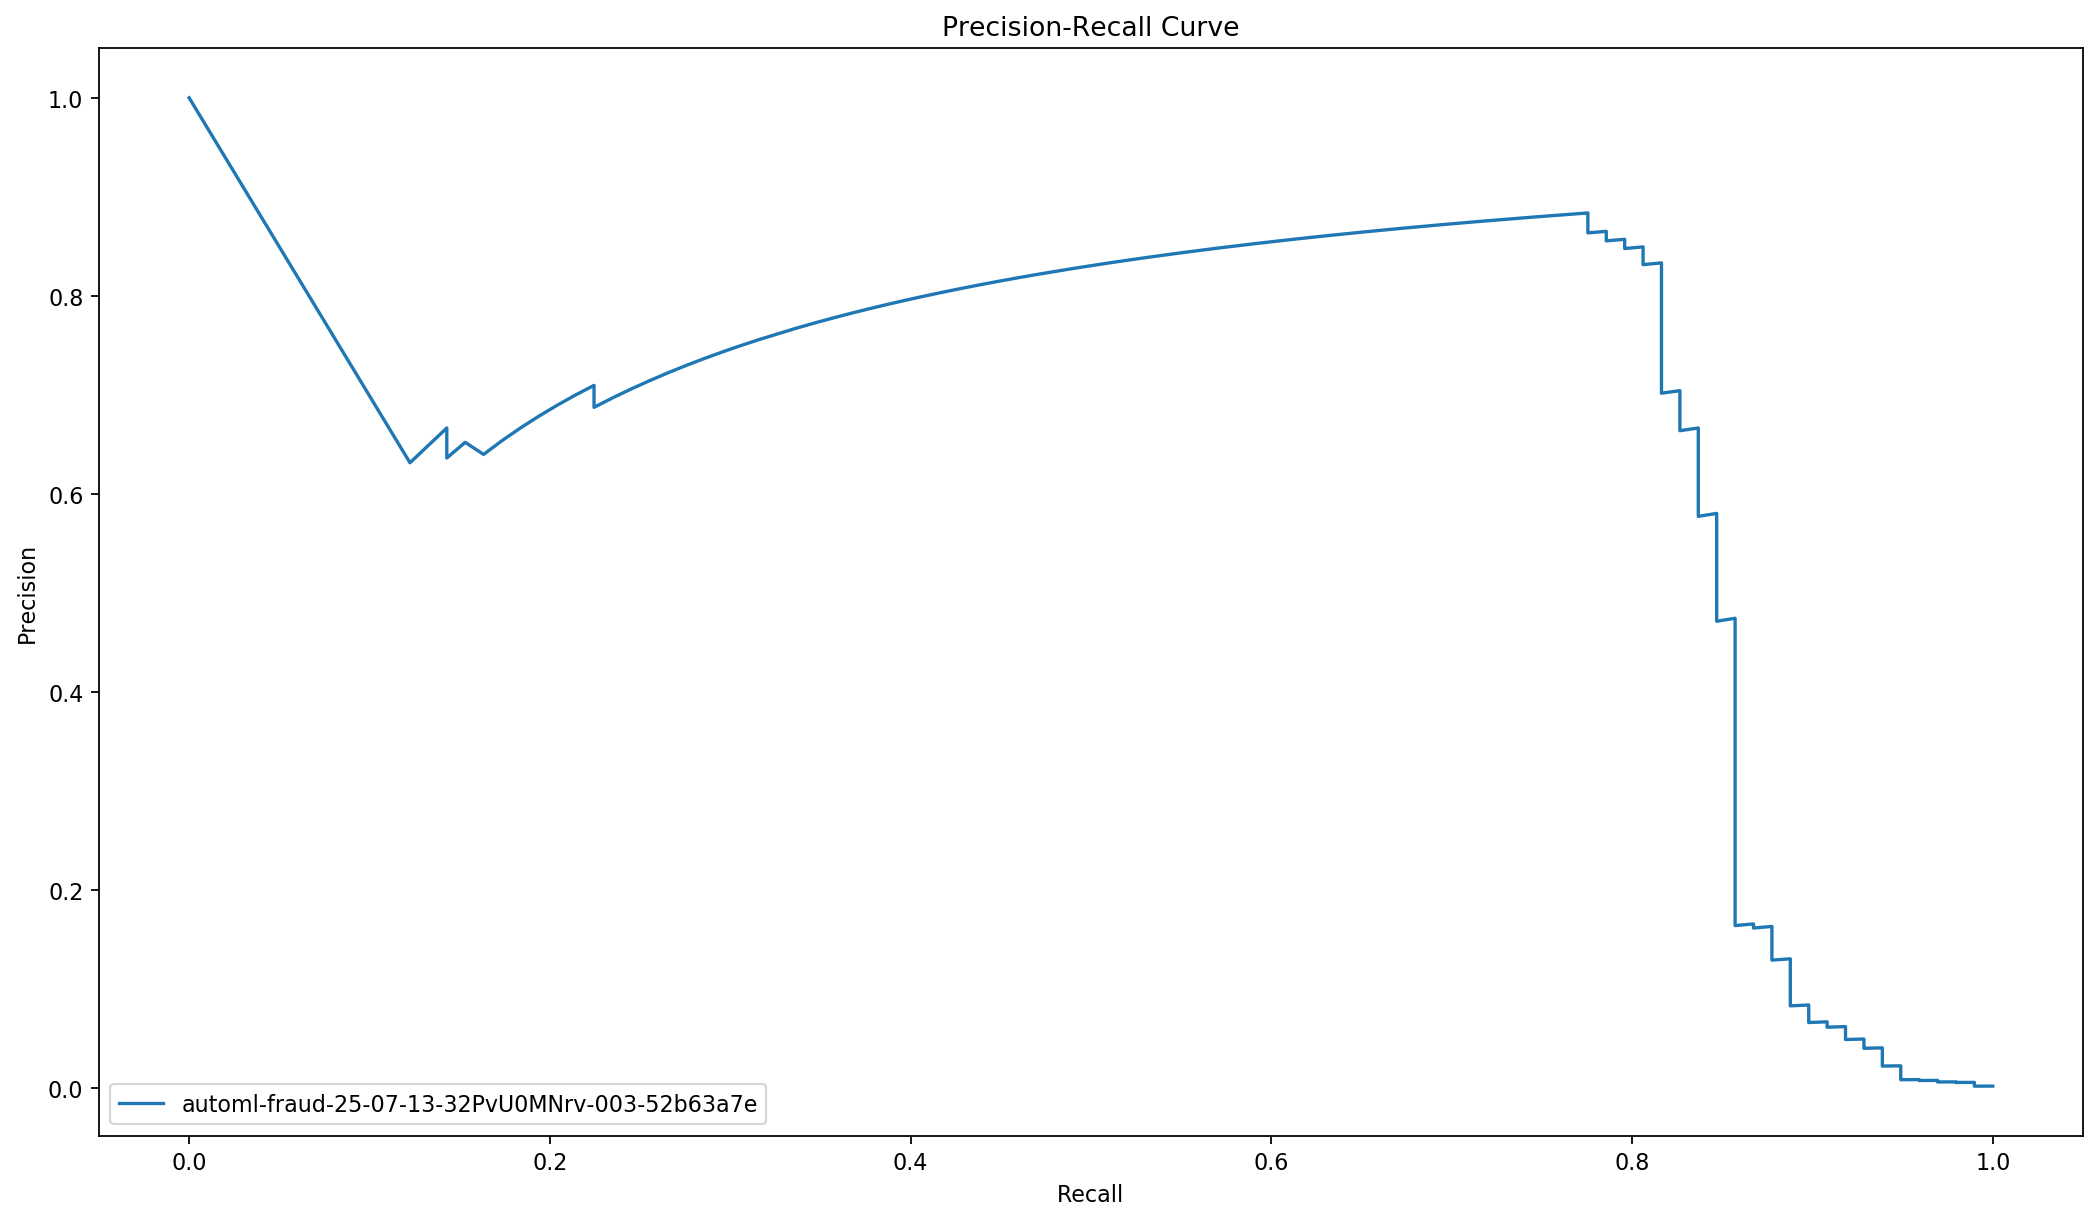

In [31]:
precision_recall = []
for prediction in predictions:
    precision, recall, _ = precision_recall_curve(labels, prediction.loc[:, 1])
    precision_recall.append(recall)
    precision_recall.append(precision)

plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor="w", edgecolor="k")
plt.plot(*precision_recall)
plt.legend([candidate["CandidateName"] for candidate in candidates], loc="lower left")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

Given the target minimal precision, we will find the model that provides the best recall and the operation point for that model.

In [32]:
target_min_precision = 0.75

best_recall = 0
best_candidate_idx = -1
best_candidate_threshold = -1
candidate_idx = 0
for prediction in predictions:
    precision, recall, thresholds = precision_recall_curve(labels, prediction.loc[:, 1])
    threshold_idx = np.argmax(precision >= target_min_precision)
    if recall[threshold_idx] > best_recall:
        best_recall = recall[threshold_idx]
        best_candidate_threshold = thresholds[threshold_idx]
        best_candidate_idx = candidate_idx
    candidate_idx += 1

print("Best Candidate Name: {}".format(candidates[best_candidate_idx]["CandidateName"]))
print("Best Candidate Threshold (Operation Point): {}".format(best_candidate_threshold))
print("Best Candidate Recall: {}".format(best_recall))

Best Candidate Name: automl-fraud-25-07-13-32PvU0MNrv-003-52b63a7e
Best Candidate Threshold (Operation Point): 0.6364922523498535
Best Candidate Recall: 0.8163265306122449


Get predictions of the best model based on the selected operating point.

In [33]:
prediction_default = predictions[best_candidate_idx].loc[:, 0] == target_attribute_true_value
prediction_updated = predictions[best_candidate_idx].loc[:, 1] >= best_candidate_threshold

# compare the updated predictions to Autopilot's default
from sklearn.metrics import precision_score, recall_score

print(
    "Default Operating Point: recall={}, precision={}".format(
        recall_score(labels, prediction_default), precision_score(labels, prediction_default)
    )
)
print(
    "Updated Operating Point: recall={}, precision={}".format(
        recall_score(labels, prediction_updated), precision_score(labels, prediction_updated)
    )
)

Default Operating Point: recall=0.8571428571428571, precision=0.2857142857142857
Updated Operating Point: recall=0.8163265306122449, precision=0.7547169811320755


---
## Cleanup <a name="Cleanup"></a>

The Autopilot job creates many underlying artifacts such as dataset splits, preprocessing scripts, or preprocessed data, etc. This code, when un-commented, deletes them. This operation deletes all the generated models and the auto-generated notebooks as well. 

In [ ]:
# s3 = boto3.resource('s3')
# s3_bucket = s3.Bucket(bucket)

# s3_bucket.objects.filter(Prefix=prefix).delete()

Finally, we delete the models and the endpoint.

In [65]:
for transformer in transformers:
    transformer.delete_model()
